In [11]:
from PIL import Image
from scipy.fft import ifft
import numpy as np
import matplotlib.pyplot as plt




In [10]:
im = Image.open("../../data/vehicle-type-detection/pickup/PIC_0.jpg")

print(im.format, im.size, im.mode)

im.show()

JPEG (313, 241) RGB


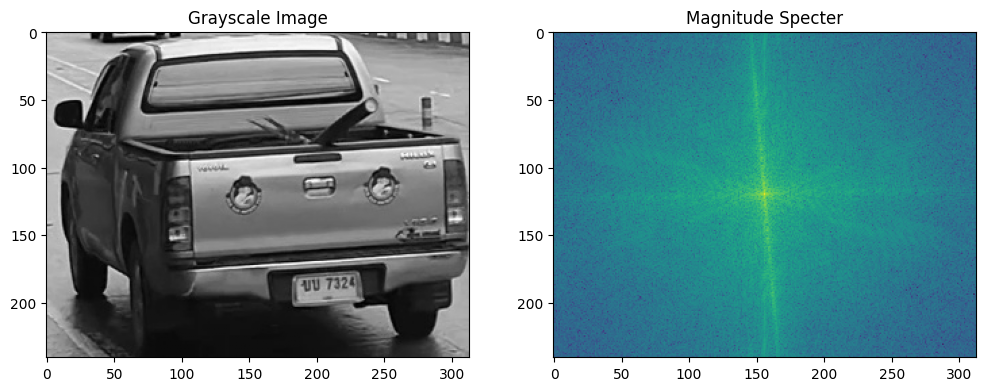

In [18]:
im = im.convert("L")

im_np = np.array(im)

F = np.fft.fft2(im_np)
F_shifted = np.fft.fftshift(F)

magn_spectr = np.log(1+np.abs(F_shifted))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("Grayscale Image")
plt.imshow(im_np, cmap="gray")

plt.subplot(1, 2, 2)
plt.imshow(magn_spectr)
plt.title("Magnitude Specter")
plt.show()


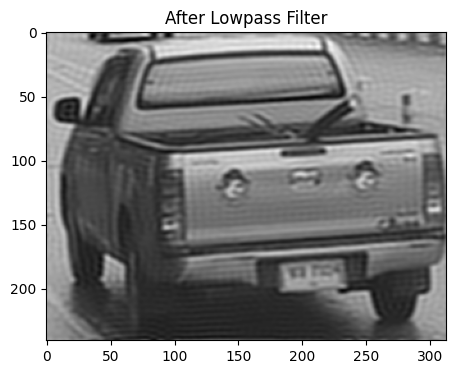

In [21]:
rows, cols = im_np.shape
crow, ccol = rows // 2, cols // 2
radius = 50

mask = np.zeros((rows, cols), dtype=np.uint8)
Y, X = np.ogrid[:rows,:cols]
dist_from_center = np.sqrt((X-ccol)**2 + (Y - crow)**2)
mask[dist_from_center <= radius] = 1

F_low = F_shifted * mask

F_ishift = np.fft.ifftshift(F_low)
im_lowpass = np.fft.ifft2(F_ishift).real

plt.figure(figsize=(8, 4))
plt.title("After Lowpass Filter")
plt.imshow(im_lowpass, cmap="gray")

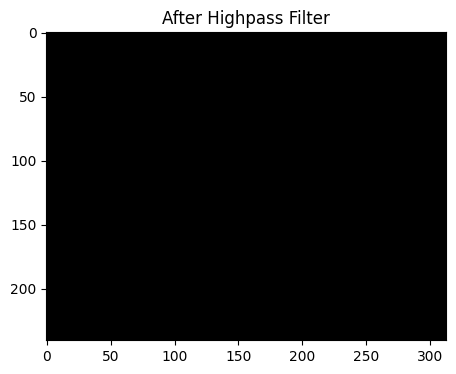

In [27]:
rows, cols = im_np.shape
crow, ccol = rows // 2, cols // 2
radius = 50

Y, X = np.ogrid[:rows,:cols]
dist_from_center = np.sqrt((X-ccol)**2 + (Y - crow)**2)

mask = np.ones((rows, cols))
mask[dist_from_center <= radius] = 0

F_high = F_shifted * mask

F_ishift = np.fft.ifftshift(F_high)
im_highpass = np.fft.ifft2(F_ishift).real

plt.figure(figsize=(8, 4))
plt.title("After Highpass Filter")
plt.imshow(im_lowpass, cmap="gray")

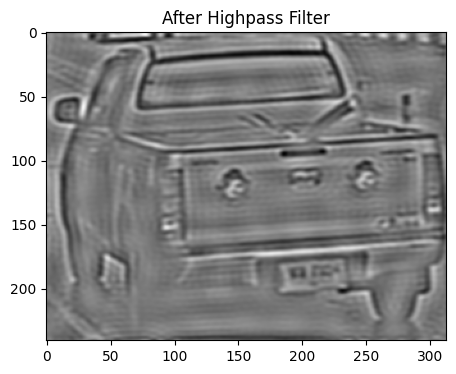

In [41]:
rows, cols = im_np.shape
crow, ccol = rows // 2, cols // 2
radius = 10

mask = np.zeros((rows, cols), dtype=np.uint8)
Y, X = np.ogrid[:rows,:cols]
dist_from_center = np.sqrt((X-ccol)**2 + (Y - crow)**2)
mask[dist_from_center >= radius] = 1

F_high = F_shifted * mask

F_ishift = np.fft.ifftshift(F_high)
im_highpass = np.fft.ifft2(F_ishift).real

plt.figure(figsize=(8, 4))
plt.title("After Highpass Filter")
plt.imshow(im_highpass, cmap="gray")

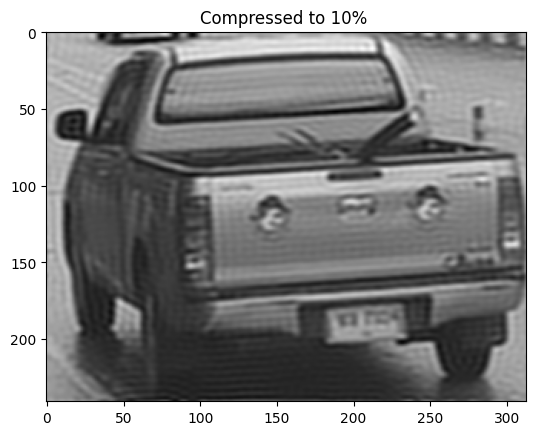

In [47]:
magnitude = np.abs(F_shifted)
compress = 90
threshold = np.percentile(magnitude, compress)
F_compressed = F_shifted * (magnitude >= threshold)

im_compressed = np.fft.ifft2(np.fft.ifftshift(F_compressed)).real

plt.title(f"Compressed to {100 - compress}% ")
plt.imshow(im_compressed, cmap="gray")